In [8]:
import pandas as pd
import numpy as np
import talib
from gym import spaces
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.utils import get_schedule_fn
import matplotlib.pyplot as plt
import time
import mplfinance as mpf
from ipywidgets import interact, widgets
import sys
import os

In [29]:
# Add the path to the system path
lib_path = os.path.abspath(os.path.join('lib'))
sys.path.append(lib_path)

def feature_engineering(df):
    open = df['open'].values
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    # volume = df['volume'].values
    hilo = (high + low) / 2

    df['RSI8'] = talib.RSI(close, timeperiod=8) # default = 14
    df['RSI14'] = talib.RSI(close, timeperiod=14)
    df['RSI_ST'] = talib.RSI(close)/close
    df['RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df['MACD'], _, _ = talib.MACD(close)
    df['MACD_ST'], _, _ = talib.MACD(close)/close
    df['ATR'] = talib.ATR(high, low, close)
    
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['+DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['-DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    
    df['SMA15'] = talib.SMA(close, timeperiod=15) # 15分足
    df['SMA300'] = talib.SMA(close, timeperiod=300) # 15分足20MA
    
    df['BB_UPPER'], df['BB_MIDDLE'], df['BB_LOWER'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] = (df['BB_UPPER'] - hilo) / close
    df['BBANDS_middleband'] = (df['BB_MIDDLE'] - hilo) / close
    df['BBANDS_lowerband'] = (df['BB_LOWER'] - hilo) / close

    df['STOCH_K'], df['STOCH_D'] = talib.STOCH(high, low, close)/close
    df['MON'] = talib.MOM(close, timeperiod=5)

    df['pinbar'] = pinbar(df)
    df['RCI'] = df['close'].rolling(9).apply(calc_rank_correlation)

    df = df.fillna(method='ffill')
    df = df.dropna()

    return df

def pinbar(df):
    body = np.abs(df['close'] - df['open'])
    upper_wick = df['high'] - np.max(df[['open', 'close']], axis=1)
    lower_wick = np.min(df[['open', 'close']], axis=1) - df['low']
    total_length = df['high'] - df['low']
    
    # 上向きのピンバー（ロングサイン）:下ワックが本体の3倍以上、上ワックが全体の長さの20~30%以内
    is_bullish_pinbar = (lower_wick >= 3 * body) & (upper_wick <= total_length * 0.3)
    
    # 下向きのピンバー（ショートサイン）:上ワックが本体の3倍以上、下ワックが全体の長さの20~30%以内
    is_bearish_pinbar = (upper_wick >= 3 * body) & (lower_wick <= total_length * 0.3)
    
    # 上向きピンバー = 1、下向きピンバー = 2、ピンバーでない = 0
    return np.where(is_bullish_pinbar, 1, np.where(is_bearish_pinbar, 2, 0))

def calc_rank_correlation(series):
    n = len(series)
    ranks = series.rank()
    sum_diffs_squared = sum((ranks - np.arange(n) - 1) ** 2)
    return 1 - 6 * sum_diffs_squared / (n * (n ** 2 - 1))

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

In [23]:
class TradingEnvInference(gym.Env):
    def __init__(self, df, initial_cash=1000000, initial_holdings=0):
        super(TradingEnvInference, self).__init__()

        self.df = df
        self.reward_range = (0, np.inf)
        self.action_space = spaces.Discrete(4)  # 0: Hold, 1: Buy, 2: Sell, 3: Cover
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(self.df.columns) + 2,))

        # Add history for plotting
        self.history = []
        self.cash = initial_cash
        self.holdings = initial_holdings

    def step(self, action):
        done = False
        obs = self.df.iloc[self.current_step]
        
        previous_cash = self.cash
        previous_holdings = self.holdings

        if action == 1:  # Buy
            if self.holdings >= 0:  # normal position
                self.cash -= obs['close']
                self.holdings += 1
            else:  # short position
                # Can't buy when holding a short position
                pass
        elif action == 0:  # Hold
            pass
        elif action == 2:  # Sell
            if self.holdings > 0:  # normal position
                self.cash += obs['close']
                self.holdings -= 1
            else:  # short position or no holdings
                # Short sell if no holdings
                self.cash += obs['close']
                self.holdings -= 1
        elif action == 3:  # Cover
            if self.holdings < 0:  # short position
                self.cash -= obs['close']
                self.holdings += 1
            else:  # normal position
                # Can't cover if not in short position
                pass

        reward = self.cash - previous_cash  # Reward is only based on change in cash

        # 1回の取引で5%以上の損失が出た場合、報酬からペナルティを引く
        if reward < -0.05 * obs['close']:
            reward -= 0.05 * obs['close']

        self.current_step += 1

        if self.current_step >= len(self.df):
            done = True

        # Save results for plotting
        self.history.append({
            'step': self.current_step,
            'cash': self.cash,
            'action': action,
            'holdings': self.holdings
        })

        return np.append(self.df.iloc[self.current_step].values, [self.holdings, self.cash])

    def reset(self):
        # 環境を初期状態にリセットするためのロジックを書く
        self.current_step = 0
        self.holdings = 0  # ポジション数
        self.cash = 1000000

        # Reset history
        self.history = []
        
        return np.append(self.df.iloc[self.current_step], [self.holdings, self.cash])
    
    # Additional function for plotting
    def plot_history(self):
        df_history = pd.DataFrame(self.history)
        df_history.set_index('step', inplace=True)

        fig, ax = plt.subplots(2, 1, sharex=True, figsize=[16, 9])

        ax[0].plot(df_history['cash'], label='Cash')
        ax[0].set_title('Cash')
        ax[0].legend(loc='upper left')

        ax[1].plot(df_history['action'], label='Action', linestyle='--')
        ax[1].set_title('Action')
        ax[1].legend(loc='upper left')

        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=[16, 9])
        ax.plot(self.df.index, self.df['close'], label='Close Price')
        ax.set_title('Stock Price')
        ax.legend(loc='upper left')
        
        plt.show()

In [24]:
def summarize_trade_results(trade_results):
    num_trades = len(trade_results['profits'])
    num_wins = sum(1 for x in trade_results['profits'] if x > 0)
    num_losses = num_trades - num_wins

    total_return = sum(trade_results['profits'])

    average_win = sum(x for x in trade_results['profits'] if x > 0) / num_wins if num_wins > 0 else 0
    average_loss = sum(x for x in trade_results['profits'] if x < 0) / num_losses if num_losses > 0 else 0

    profit_factor = -average_win / average_loss if average_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_profits'] if x > 0) / len(trade_results['long_profits']) if trade_results['long_profits'] else 0
    short_win_rate = sum(1 for x in trade_results['short_profits'] if x > 0) / len(trade_results['short_profits']) if trade_results['short_profits'] else 0

    # Create cumulative return series
    cumulative_returns = np.cumsum(trade_results['profits'])
    cumulative_long_returns = np.cumsum(trade_results['long_profits'])
    cumulative_short_returns = np.cumsum(trade_results['short_profits'])

    # Calculate maximum drawdown using numpy
    cumulative_max = np.maximum.accumulate(cumulative_returns)
    non_zero_max = cumulative_max > 0
    drawdowns = np.full_like(cumulative_returns, fill_value=0)
    drawdowns[non_zero_max] = 1 - cumulative_returns[non_zero_max] / cumulative_max[non_zero_max]
    max_drawdown = np.max(drawdowns)
    maximum_single_trade_loss = min(trade_results['profits']) if trade_results['profits'] else 0

    # Print the statistics
    print(f"Total Return: {total_return:.2f}")
    print(f"Total Trade Num: {len(trade_results['profits'])}")
    print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
    print(f"Max Single Trade Loss: {maximum_single_trade_loss:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Long Trade Num: {len(trade_results['long_profits'])}")
    print(f"Long Win Rate: {long_win_rate * 100:.2f}%")
    print(f"Short Trade Num: {len(trade_results['short_profits'])}")
    print(f"Short Win Rate: {short_win_rate * 100:.2f}%")

    # Plot the results
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns, label='Total Returns')
    plt.title("Cumulative Total Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_long_returns, label='Long Returns', color='blue')
    plt.plot(cumulative_short_returns, label='Short Returns', color='red')
    plt.title("Cumulative Long and Short Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
def initPortfolio():
    portfolio = {
        'position': None,  # "long" or "short"
        'entry_price': None,
        'entry_point': 0
    }
    return portfolio

In [36]:
def predict(model, state):
    # Reshape the data_row into the correct format
    state = state.reshape(1, -1)
    # model.predict(state) の返り値は (actions, states) のタプル
    actions, _ = model.predict(state)
    return actions[0]

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_64956/2590614013.py:75: RuntimeWarning: invalid value encountered in log
  return np.log(X)


,date,open,high,low,close,RSI8,RSI14,RSI_ST,RSI_LOG,MACD,...,BB_MIDDLE,BB_LOWER,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,STOCH_K,STOCH_D,MON,pinbar,RCI
299,17940.0,4154.0,4154.2,4152.5,4152.6,49.456368,53.859684,0.012970,3.986382,1.192243,...,4151.955,4148.410159,0.000518,-0.000336,-0.001190,0.006010,0.008417,-2.7,0,0.162500
300,18000.0,4152.7,4153.0,4151.7,4151.7,43.863617,50.147586,0.012079,3.914970,1.005249,...,4152.050,4148.642068,0.000749,-0.000072,-0.000893,0.004291,0.006782,-1.3,0,-0.437500
301,18060.0,4151.7,4152.6,4149.7,4149.9,34.854470,43.665579,0.010522,3.776560,0.703698,...,4152.095,4148.828519,0.001015,0.000228,-0.000559,0.000592,0.003633,-3.8,0,-0.787500
302,18120.0,4149.4,4150.7,4149.4,4150.2,37.307134,44.942918,0.010829,3.805393,0.483352,...,4152.145,4149.030213,0.001255,0.000505,-0.000246,0.001505,0.002130,-3.2,0,-0.833333
303,18180.0,4150.3,4152.2,4150.2,4151.7,48.406757,50.933537,0.012268,3.930522,0.424866,...,4152.235,4149.285237,0.000960,0.000249,-0.000461,0.005351,0.002482,-2.5,0,-0.754167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,66000.0,4155.0,4155.0,4154.5,4154.7,40.610603,46.375496,0.011162,3.836771,0.177781,...,4154.960,4153.348293,0.000438,0.000051,-0.000337,0.006151,0.013396,-0.8,0,-0.087500
996,66060.0,4154.7,4155.2,4154.7,4155.2,49.035756,50.772642,0.012219,3.927358,0.156580,...,4155.005,4153.419472,0.000395,0.000013,-0.000368,0.003610,0.007710,-0.5,0,-0.250000
997,66120.0,4155.3,4155.8,4155.2,4155.5,53.553912,53.249655,0.012814,3.974991,0.162117,...,4155.130,4153.827541,0.000224,-0.000089,-0.000402,0.007620,0.005793,-1.0,0,-0.275000
998,66180.0,4155.5,4155.5,4154.7,4155.0,45.817071,48.838824,0.011754,3.888526,0.124721,...,4155.195,4154.066328,0.000295,0.000023,-0.000249,0.009493,0.006908,-1.0,0,-0.550000


Index(['date', 'open', 'high', 'low', 'close', 'RSI8', 'RSI14', 'RSI_ST',
       'RSI_LOG', 'MACD', 'MACD_ST', 'ATR', 'ADX', 'ADXR', '+DI', '-DI',
       'SMA15', 'SMA300', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER',
       'BBANDS_upperband', 'BBANDS_middleband', 'BBANDS_lowerband', 'STOCH_K',
       'STOCH_D', 'MON', 'pinbar', 'RCI'],
      dtype='object')
columns number: 29
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/tek/dev/python/gmo-algo-trading/myenv/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(
/Users/tek/dev/python/gmo-algo-trading/myenv/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


Total Return: 3.90
Total Trade Num: 701
Max Drawdown: 88.24%
Max Single Trade Loss: -2.30
Profit Factor: 12.48
Long Trade Num: 53
Long Win Rate: 50.94%
Short Trade Num: 59
Short Win Rate: 52.54%


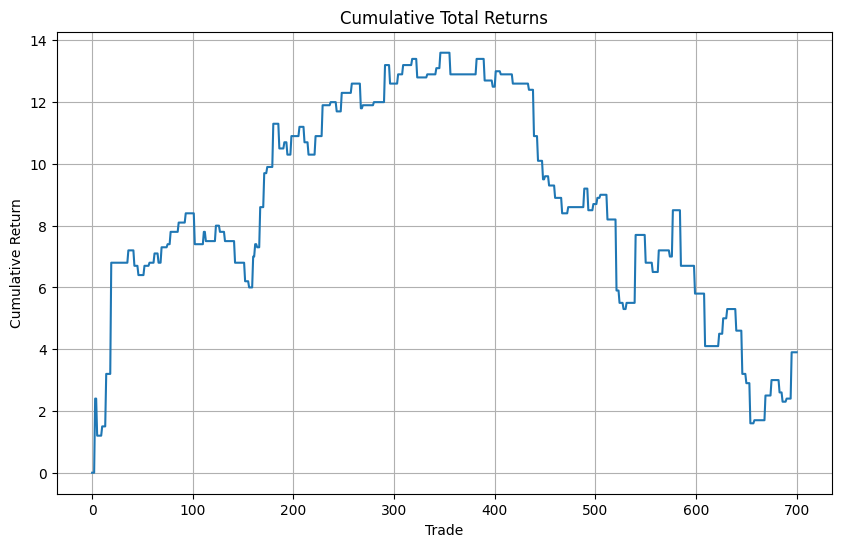

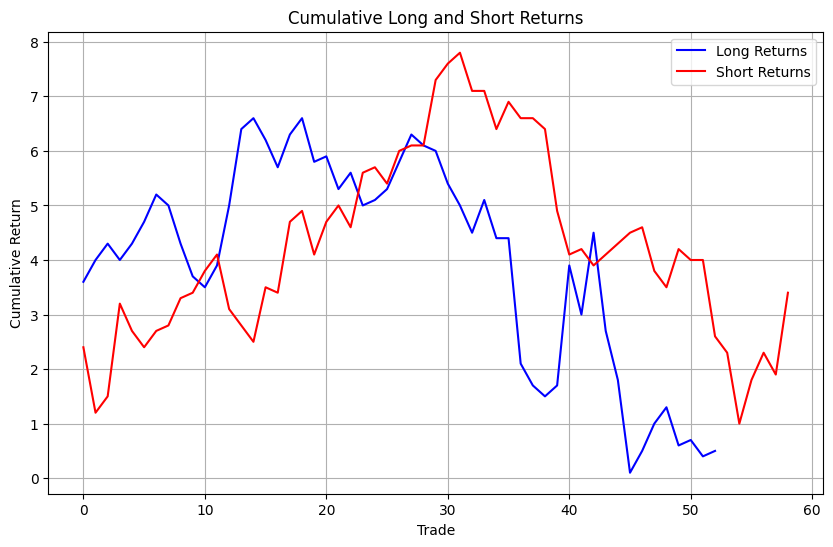

In [37]:
if __name__ == "__main__":
    df = pd.read_csv('../csv/test_combined_data_small_2.csv')
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = (df['date'] - df['date'].min()).dt.total_seconds() 

    df = feature_engineering(df)
    display(df)
    print(df.columns)
    print(f'columns number: {len(df.columns)}')

    env = TradingEnvInference(df, initial_cash=1000000, initial_holdings=0)
    model = PPO.load("../model/PPO", env=env, clip_range=get_schedule_fn(0.2))

    # Initialize trade_results
    trade_results = {
        'profits': [],
        'long_profits': [],
        'short_profits': [],
    }

    # Initialize portfolio state
    portfolio = initPortfolio()

    # Loop through the data
    for i in range(0, len(df)):
        profit = 0

        # Get the current row of data
        data_row = df.iloc[i]
        prev_row = df.iloc[i-1]

        # Get the current row of data
        state = np.append(df.iloc[i].values, [env.cash, env.holdings])

        # Make a prediction with the model
        action = predict(model, state)

        # Exit
        if portfolio['position'] is not None:
            if portfolio['position'] == 'long':
                if action == 2:

                    profit = data_row['close'] - portfolio['entry_price']
                    trade_results['profits'].append(profit)
                    trade_results['long_profits'].append(profit)
                    portfolio = initPortfolio()
                
                else:
                    trade_results['profits'].append(0)
            elif portfolio['position'] == 'short':
                if action == 3:
                    
                    profit = portfolio['entry_price'] - data_row['close']
                    trade_results['profits'].append(profit)
                    trade_results['short_profits'].append(profit)
                    portfolio = initPortfolio()

                else:
                    trade_results['profits'].append(0)
            else:
                trade_results['profits'].append(0)
        
        # Short Entry
        elif action == 2:
            trade_results['profits'].append(0)
            portfolio = {
                'position': 'short',
                'entry_price': data_row['close'],
                'entry_point': i
            }

        # Long Entry
        elif  action == 1:
            trade_results['profits'].append(0)
            portfolio = {
                'position': 'long',
                'entry_price': data_row['close'],
                'entry_point': i
            }

        else:
            trade_results['profits'].append(0)

    summarize_trade_results(trade_results)



In [33]:
def plot_candlestick(start, end):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    
    plot_df = df.loc[start:end]
    ohlc_df = plot_df[['open', 'high', 'low', 'close']]
    ohlc_df.columns = ['open', 'high', 'low', 'close']
    
    mpf.plot(ohlc_df, type='line', style='yahoo', volume=False, tight_layout=True, warn_too_much_data=7000000)

start_date = widgets.DatePicker(
    description='Start Date',
    value=pd.to_datetime(df.index.min()),
    disabled=False
)

end_date = widgets.DatePicker(
    description='End Date',
    value=pd.to_datetime(df.index.max()),
    disabled=False
)

interact(plot_candlestick, start=start_date, end=end_date)

interactive(children=(DatePicker(value=Timestamp('1970-01-01 00:00:00.000000299'), description='Start Date', s…

<function __main__.plot_candlestick(start, end)>